In [13]:
from os import path
import glob

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
from pyia import GaiaData

In [14]:
stream_w = np.load('../data/stream_model.npy')
stream = gd.PhaseSpacePosition(pos=stream_w[:, :3].T*u.kpc,
                               vel=stream_w[:, 3:].T*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

In [15]:
stream_gd1 = stream.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
mask = (stream_gd1.phi1.wrap_at(180*u.deg) > -120*u.deg) | (stream_gd1.phi1.wrap_at(180*u.deg) < 60*u.deg)

stream_icrs = stream.to_coord_frame(coord.ICRS, galactocentric_frame=gc_frame)[mask]

(-15, 5)

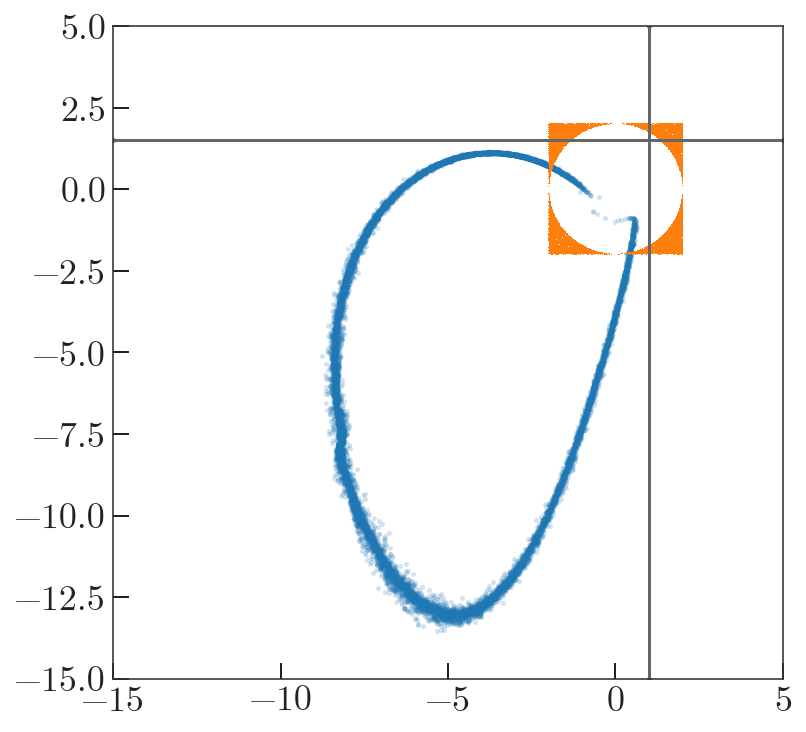

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(stream_icrs.pm_ra_cosdec.to(u.mas/u.yr).value,
        stream_icrs.pm_dec.to(u.mas/u.yr).value,
        marker='.', linestyle='none', alpha=0.2)

xx = np.random.uniform(-2, 2, size=100000)
yy = np.random.uniform(-2, 2, size=100000)
idx = np.sqrt(xx**2 + yy**2) > 2
ax.plot(xx[idx], yy[idx], linestyle='', marker=',')

ax.axvline(1)
ax.axhline(1.5)

ax.set_xlim(-15, 5)
ax.set_ylim(-15, 5)

In [17]:
q_base ='''SELECT * FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp > -0.5 AND bp_rp < 2 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1 AND
      (SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 2) AND (pmra < 1) AND (pmdec < 1.5)
'''

(4, 20)

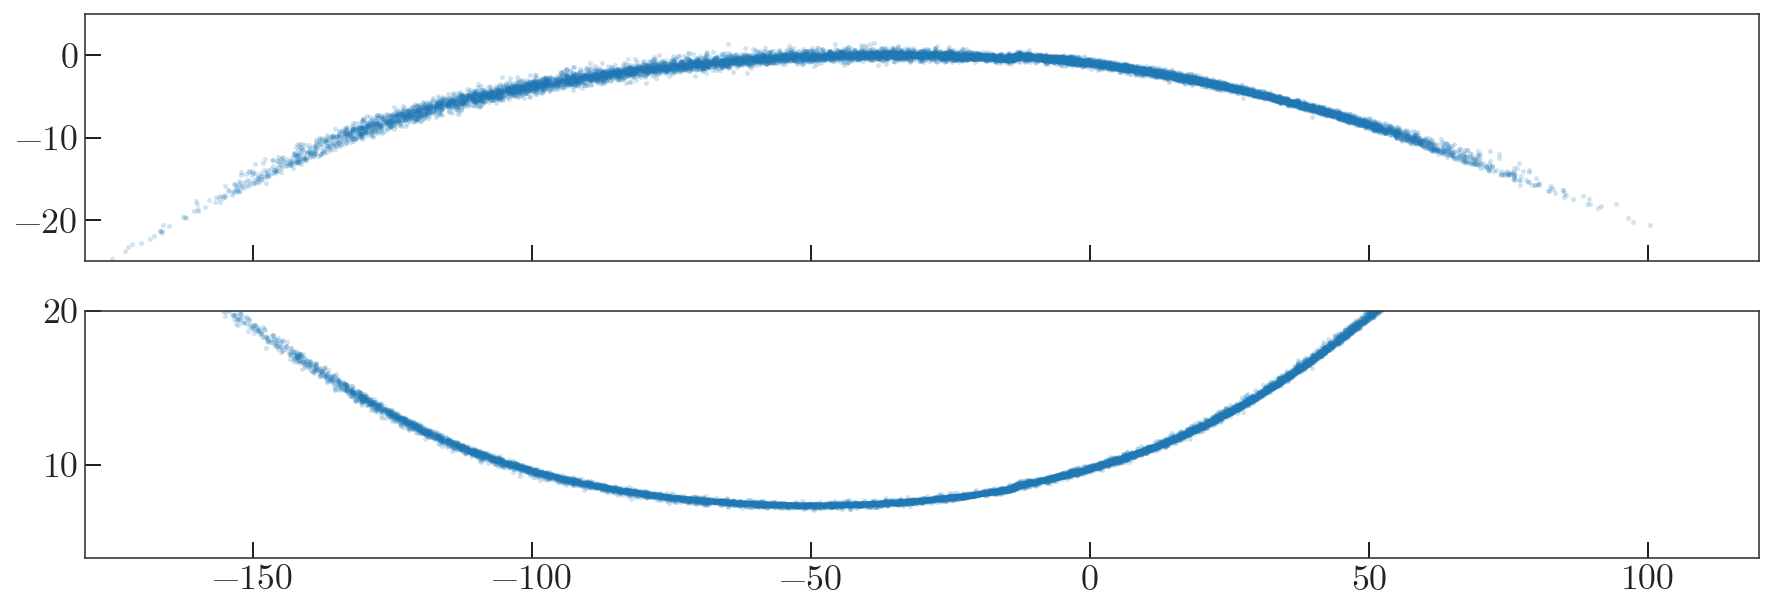

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax = axes[0]
ax.plot(stream_gd1.phi1.wrap_at(180*u.deg),
        stream_gd1.phi2, marker='.', linestyle='none', alpha=0.2)
ax.set_xlim(-180, 120)
ax.set_ylim(-25, 5)

ax = axes[1]
ax.plot(stream_gd1.phi1.wrap_at(180*u.deg),
        stream_gd1.distance, marker='.', linestyle='none', alpha=0.2)
ax.set_ylim(4, 20)

In [34]:
queries = []
for l in np.arange(-120, 50, 10):
    corners = gc.GD1(phi1=[l, l, l+10, l+10]*u.deg, 
                     phi2=[-10, 5, 5, -10]*u.deg)
    corners_icrs = corners.transform_to(coord.ICRS)
    queries.append(q_base.format(corners_icrs[0], corners_icrs[1], corners_icrs[2], corners_icrs[3]))

ERROR! Session/line number was not unique in database. History logging moved to new session 6218


In [35]:
for q in queries:
    print(q)
    print()

SELECT * FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp > -0.5 AND bp_rp < 2 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       114.06133664285393, -37.23267001446667, 
                       99.2270446061722, -28.796815725573893, 
                       105.70841891081587, -20.75275339914416, 
                       119.78295147242956, -28.62925471796403)) = 1 AND
      (SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 2) AND (pmra < 1) AND (pmdec < 1.5)


SELECT * FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp > -0.5 AND bp_rp < 2 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       119.78295147242956, -28.62925471796403, 
                       105.70841891081587, -20.75275339914416, 
                       111.39341430156357, -12.408913634684538, 
                       124.90645851283158, -19.955203131285998)) = 1 AND
      (SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 2) AND (pmra < 1)

# Combine tables

In [4]:
from numpy.lib.recfunctions import stack_arrays

In [2]:
keep_cols = ['solution_id', 'source_id', 'random_index', 'ref_epoch', 
             'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 
             'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 
             'parallax_pmdec_corr', 'pmra_pmdec_corr', 'visibility_periods_used', 
             'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error', 
             'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 
             'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux', 
             'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag', 
             'phot_bp_rp_excess_factor', 'phot_proc_mode', 'bp_rp', 'bp_g', 'g_rp', 'radial_velocity', 
             'radial_velocity_error', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 
             'e_bp_min_rp_val', 'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper']

In [3]:
all_filename = '../data/gd1-polygon/all.fits'
if not path.exists(all_filename):
    arrs = []
    for filename in glob.glob('../data/gd1-polygon/*.fits'):
        arrs.append(np.array(fits.getdata(filename))[keep_cols])
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    t = Table(arr)
    t.write(all_filename)

In [4]:
t = Table.read(all_filename)

In [8]:
c_gd1 = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg).transform_to(gc.GD1)

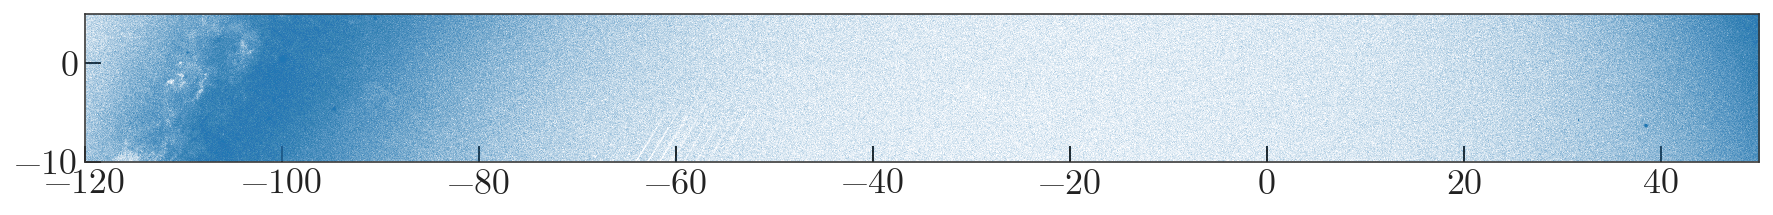

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(c_gd1.phi1.wrap_at(180*u.deg)[t['phot_g_mean_mag'] < 19],
        c_gd1.phi2[t['phot_g_mean_mag'] < 19], 
        marker=',', linestyle='none', alpha=0.04)

ax.set_xlim(-120, 50)
ax.set_ylim(-10, 5)

ax.set_aspect('equal')